### Looking for small molecule-induced polymerization targets 





This project aim was to search through ([all the homomeric AlphaFold models in human proteome](https://www.cell.com/cell/fulltext/S0092-8674(24)00059-X?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS009286742400059X%3Fshowall%3Dtrue)) to find ones that are suitable for "PINCHing"

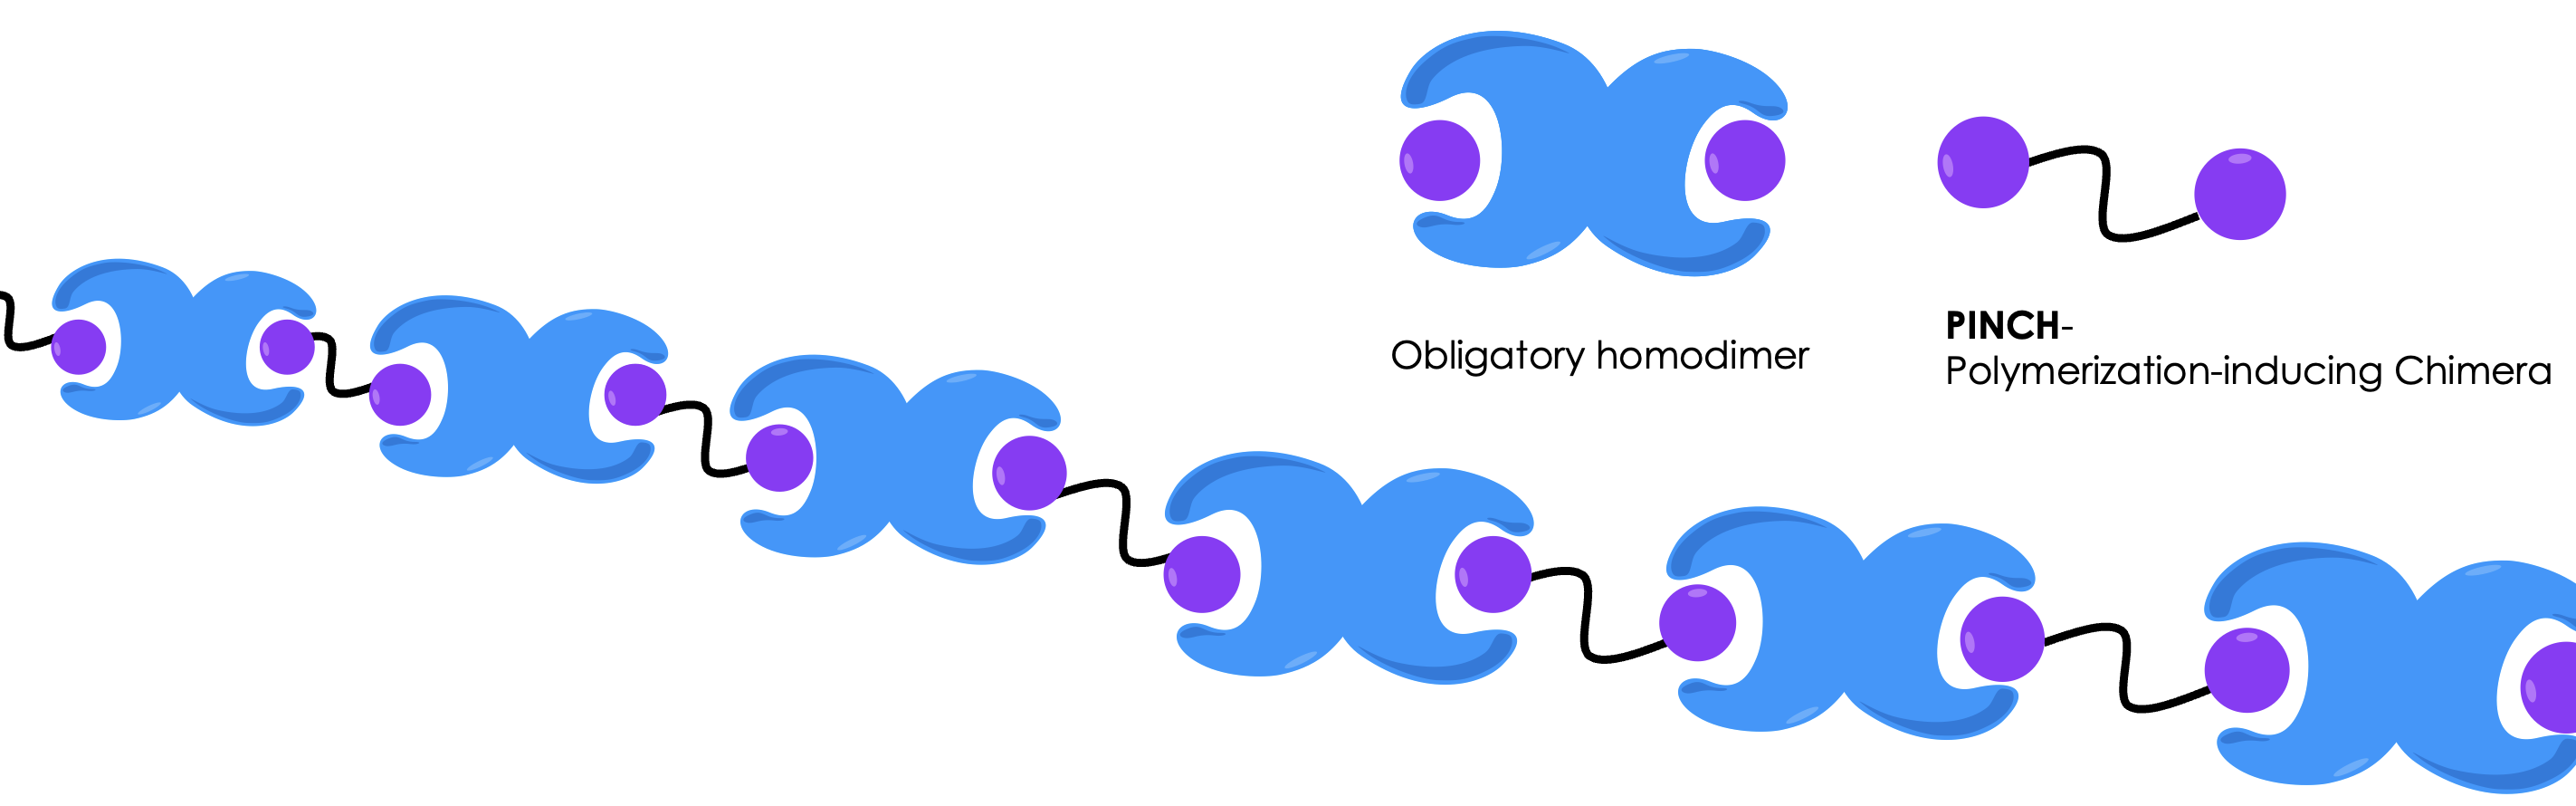

In [4]:
import IPython
IPython.display.Image('2.png', retina=True)

The idea is to find all the possible binding pockets with fpocket tool and to filter all suitable pockets in general way (drugability, solvent acess, ect. features) as well as taking into consideration arrangment limitations - we want only the equal pockets that conain a protein part between them 

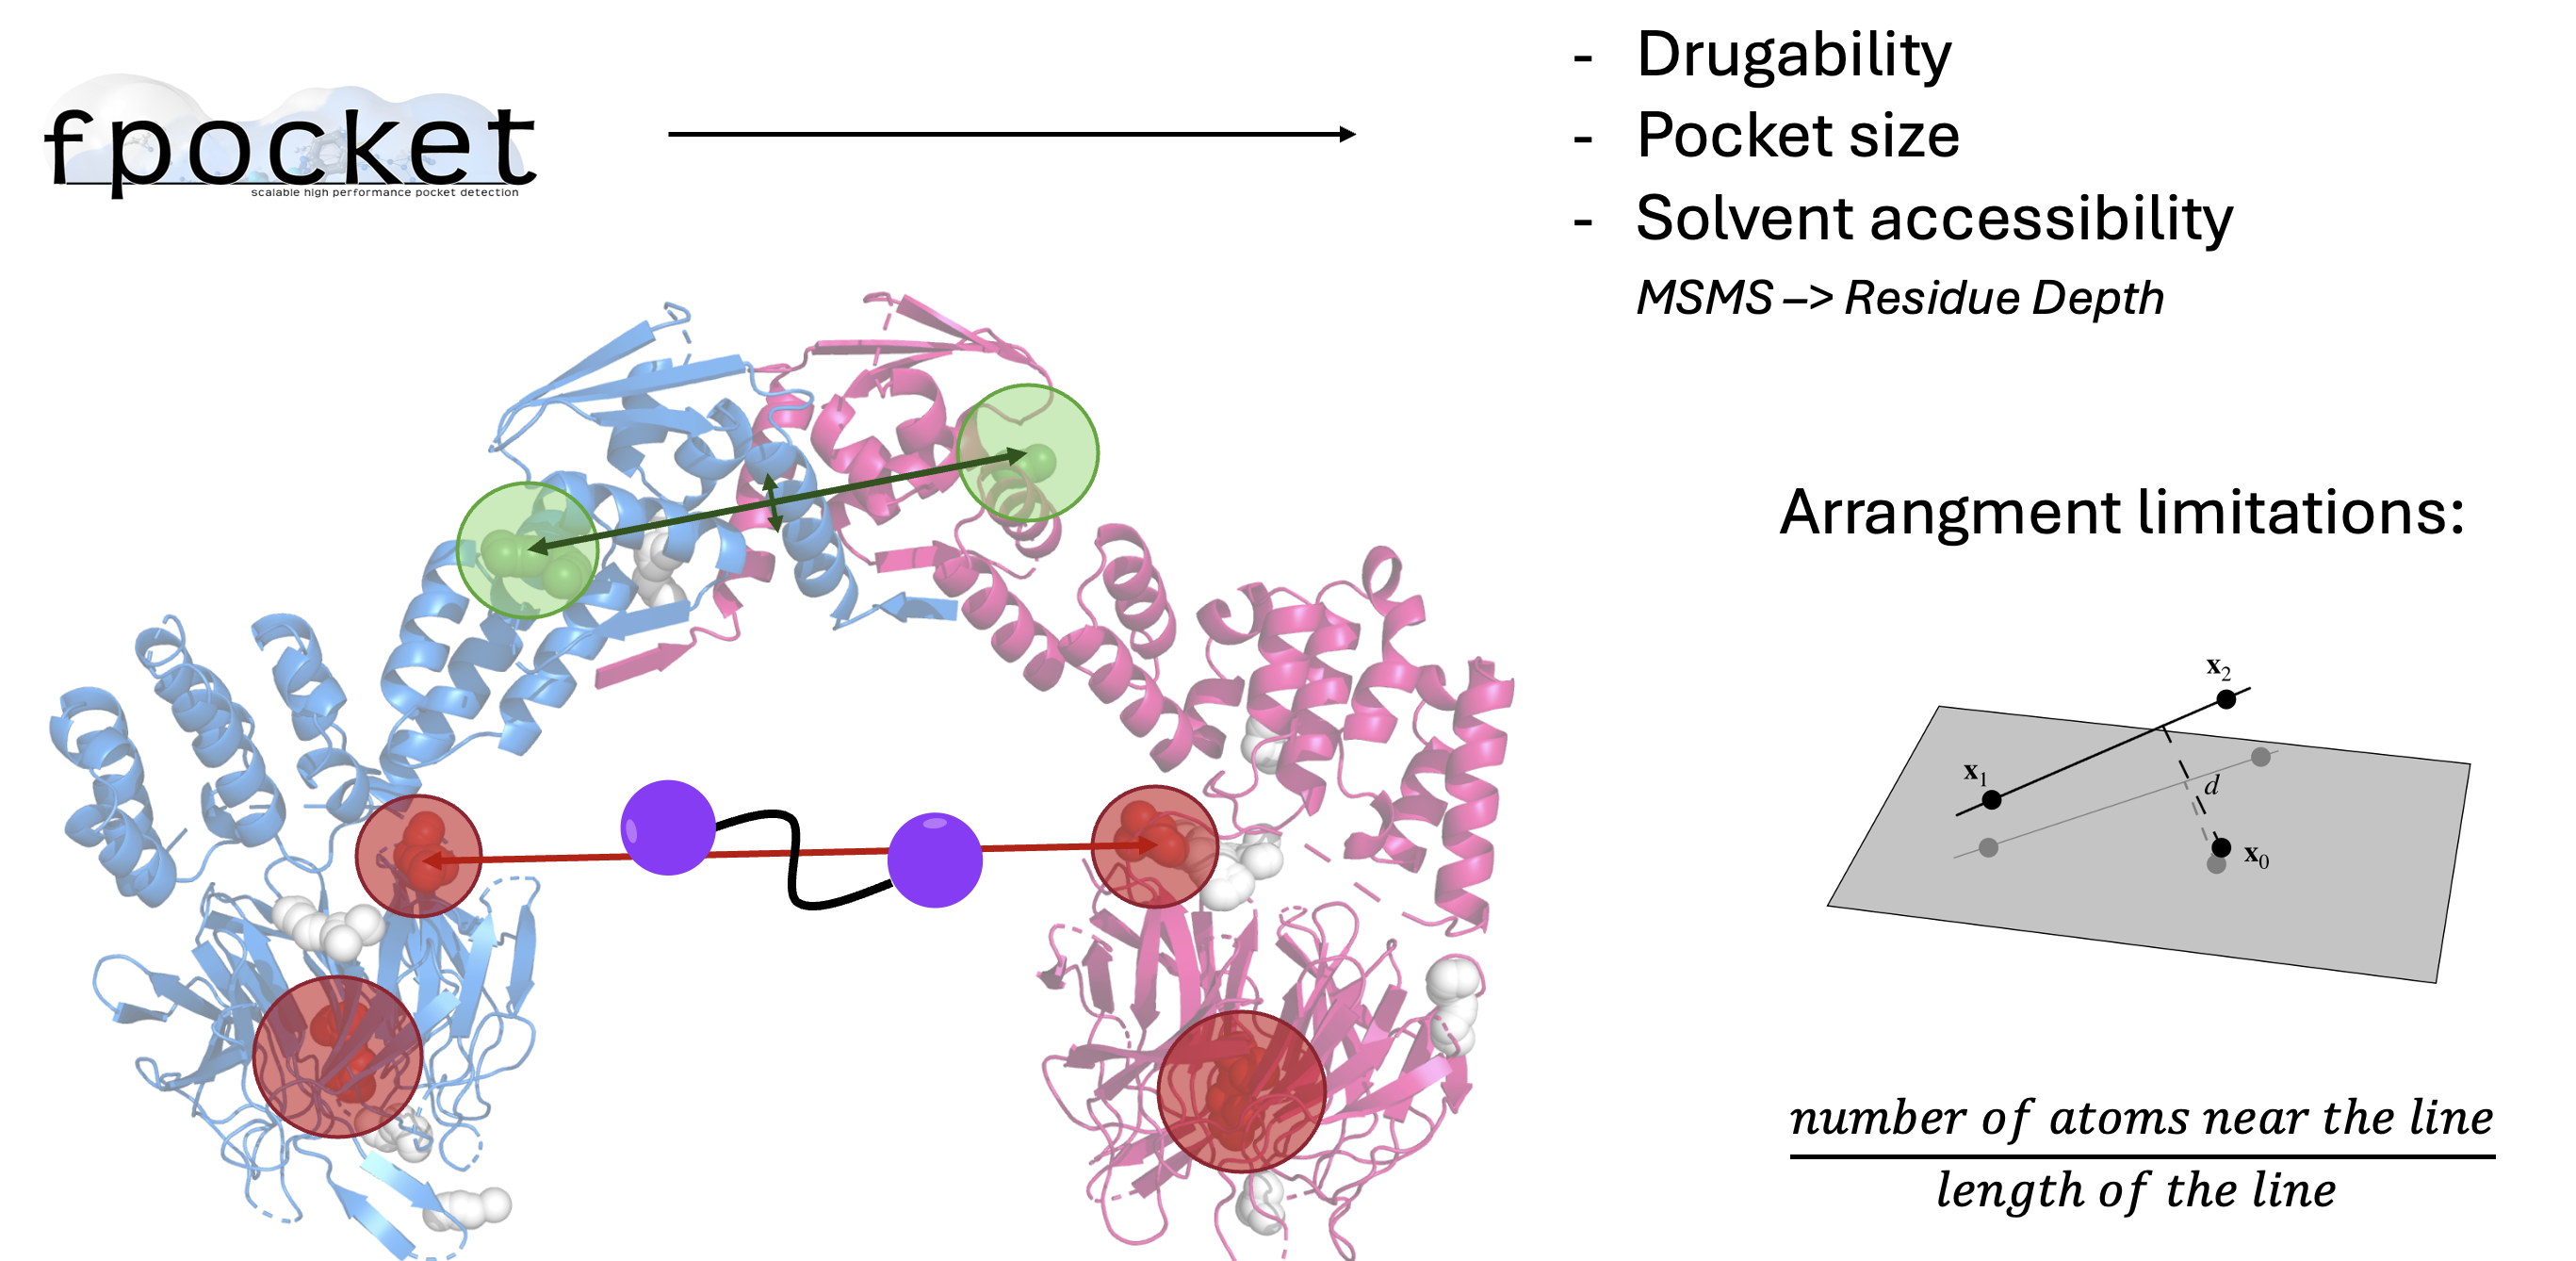

In [3]:
IPython.display.Image('1.png', retina=True)

In [11]:
import pandas as pd
import numpy as np
import math 
import re
import warnings

# import subprocess
# import glob
# import sys

from Bio import SeqIO
from Bio.PDB import Select, PDBIO, parse_pdb_header
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.ResidueDepth import get_surface
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

import scipy
from pymol import cmd, stored, util
import psico.fullinit
# ! open -a Docker && docker pull fpocket/fpocket 

##### Some functions for the script 

In [15]:
def get_com(pdb, selection = None):

    # returns the center of mass with the pymol (x, y, z)
    # whole structure or some of the residues if the selection is provided 
    # selection is written the same way as in pymol command

    cmd.delete('all')
    cmd.load(f'./workdir/{pdb}.pdb')

    if selection:
        cmd.create('selected', f'{selection}')
        return cmd.centerofmass('selected')
    else:
        return cmd.centerofmass()


def get_rg(pdb, selection = False, start = 0, end = 0):
    cmd.delete('all')
    cmd.load(f'./workdir/{pdb}.pdb')

    # returns the rg with the pymol
    # whole structure or some of the residues if the selection is provided 
    # selection is written the same way as in pymol command

    if selection:
        cmd.create('selected', f'resi {start}-{end}')
        return cmd.gyradius('selected')
    else:
        return cmd.gyradius()


def get_chains_pdb(pdb):

    # returs the list of chains of the structure 

    chains = []
    pdb = PDBParser().get_structure("", f'./workdir/{pdb}.pdb')
    for chain in pdb.get_chains():
        chains.append(chain.id)
    return chains


def first_resi_in_pdb(pdb):

    # returns the number of the first residue
    # since AF stuctures from the paper residues numbering starts not from the 1 

    file = PDBParser().get_structure("", f'./workdir/{pdb}.pdb')
    model = file[0]
    residues = []
    for model in file:
        for chain in model: 
            for resi in chain.get_residues():
                residues.append(resi.id[1])
    return int(residues[0])


def merge_ranges(ranges):

    # for finding domains from the hhmer output - overlap the ranges 
    
    if not ranges:
        return []
    ranges = [(r.start, r.stop - 1) for r in ranges]
    ranges.sort(key=lambda x: x[0])
    merged_ranges = [ranges[0]]

    for current in ranges[1:]:
        last_merged = merged_ranges[-1]
        if current[0] <= last_merged[1] + 1:
            merged_ranges[-1] = (last_merged[0], max(last_merged[1], current[1]))
        else:
            merged_ranges.append(current)
    merged_ranges = [range(start, end + 1) for start, end in merged_ranges]

    return merged_ranges


def hhmer(pdb):

    # returns functional domains ranges  
    # scans the sequence agains Pfam-A db 
    
    for record in SeqIO.parse(f'./workdir/{pdb}.pdb', "pdb-atom"):
        SeqIO.write(record, f"./hmmer/tmp/{pdb}.fasta", "fasta")
    hmm_output = ! hmmscan ./hmmer/Pfam-A.hmm ./hmmer/tmp/{pdb}.fasta
    func_regions = []
    for region in hmm_output:
        if '!' in region:
            func_regions.append(range(int(region.split()[12]) + first_resi_in_pdb(pdb), 
                                      int(region.split()[13]) + first_resi_in_pdb(pdb)))

    return merge_ranges(func_regions)


def distance_between_coms(point1, point2):

    # returns distance between two points in space with given (x, y, z)

    x1, y1, z1 = point1
    x2, y2, z2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)


def calculate_overlap(resi1, resi2):

    # overlap of the residues from the pockets to find symmetrical groups 

    set1, set2 = set(resi1), set(resi2)
    overlap = set1.intersection(set2)
    return len(overlap) / min(len(set1), len(set2))


def symmetrical_pockets(pockets_list):

    # find pockets that share same residues (can be the same chains if the pockets are splitted) 
    # or from different chains symmetrical pockets

    pocket_resi = {}
    for pocket in pockets_list:
        # pocket_resi[pocket.number + '.' + pocket.resi_chain()[sorted(pocket.resi_chain().keys(), key = int)[0]]] = pocket.resi() 
        pocket_resi[pocket.number] = pocket.resi() 

    groups = []
    for pocket_number, pocket_residues in pocket_resi.items():
        added_to_group = False

        for group in groups:
            for resi in group['residues']:
                
                if  calculate_overlap(pocket_residues, resi) >= 0.8:
                    
                    group['pockets'].append(pocket_number)
                    group['residues'].append(pocket_residues)
                    added_to_group = True
                    break 
                
        if not added_to_group:
            groups.append({'pockets': [pocket_number], 'residues': [pocket_residues]})

    return groups


def min_dist(coord, surface):

    # returns distance between coordinate and MSMS surface 
    # from BioPython 

    d = surface - coord
    d2 = np.sum(d * d, 1)
    return np.sqrt(min(d2))


def residue_depth(residue, surface):

    # returns residue depth (mean distances of atoms to the surface)
    # from BioPython 

    atom_list = residue.get_unpacked_list()
    length = len(atom_list)
    d = 0
    for atom in atom_list:
        coord = atom.get_coord()
        d = d + min_dist(coord, surface)
    return d / length


def residues_depth(pdb):

    # returns mean pocket's residues depth 

    rv = {}
    parser = PDBParser()
    structure = parser.get_structure("", f"./workdir/{pdb}.pdb")
    model = structure[0]

    surface = get_surface(model, MSMS = './msms_x86_64Darwin_2.6.1/msms.x86_64Darwin.2.6.1')

    for model in structure:
        for chain in model.get_chains():
            for residue in chain.get_residues():
                rv[str(residue.id[1]) + chain.id] = residue_depth(residue, surface)
    
    return rv 

### Pocket features 
##### Here we make a pocket class where we store all the pocket features from the fpocket tool output 


In [12]:
class Pocket:
    def __init__(self, pdb, number):
        self.pdb = pdb
        self.number = number


    def chain(self): # list of the chains that belong to the pocket's residue
        chains = []
        file = PDBParser().get_structure("", f'./workdir/{self.pdb}_out/pockets/pocket{self.number}_atm.pdb')
        for chain in file.get_chains():
            chains.append(chain.id)
        return chains

    def com(self): # center of mass of the pocket's residues 
        return get_com(f'{self.pdb}_out/pockets/pocket{self.number}_atm')
    
    def resi(self): # sorted list of the residues 
        residues = []
        file = PDBParser().get_structure("", f'./workdir/{self.pdb}_out/pockets/pocket{self.number}_atm.pdb')
        model = file[0]
        for model in file:
            for chain in model:
                for r in chain.get_residues():
                    residues.append(r.id[1])
        return sorted(residues)
    
    def resi_chain(self): # dictionary of the residues and the chains of these residues 
        rv = {}
        file = PDBParser().get_structure("", f'./workdir/{self.pdb}_out/pockets/pocket{self.number}_atm.pdb')
        model = file[0]
        for model in file:
            for chain in model:
                for r in chain.get_residues():
                    rv[r.id[1]] = chain.id
        return rv
    
    def drugability(self): # fpocket output: drugability score 
        with open(f'./workdir/{self.pdb}_out/{self.pdb}_info.txt', 'r') as file:
            text = file.read().split('\n\n')
            for pock in text:
                if pock.startswith(f'Pocket {self.number}'):
                    return float(pock.split('\t')[4][:-1])
    
    def alpha_spheres(self): # fpocket output: number of alpha spheres
        with open(f'./workdir/{self.pdb}_out/{self.pdb}_info.txt', 'r') as file:
            text = file.read().split('\n\n')
            for pock in text:
                if pock.startswith(f'Pocket {self.number}'):
                    return float(pock.split('\t')[6][:-1])
            

    def solvent_access(self): # fpocket output: mean alp. sph. solvent access
        with open(f'./workdir/{self.pdb}_out/{self.pdb}_info.txt', 'r') as file:
            text = file.read().split('\n\n')
            for pock in text:
                if pock.startswith(f'Pocket {self.number}'):
                    return float(pock.split('\t')[20][:-1])
                
    def max_dist_from_com(self): # fpocket output: cent. of mass - alpha sphere max dist
        with open(f'./workdir/{self.pdb}_out/{self.pdb}_info.txt', 'r') as file:
            text = file.read().split('\n\n')
            for pock in text:
                if pock.startswith(f'Pocket {self.number}'):
                    return float(pock.split('\t')[36][:-1])
                
    def mean_max_depth(self): # mean and max residue depth
        residuess_depth = residues_depth(self.pdb)
        list_residues = [f"{key}{value}" for key, value in self.resi_chain().items()]
        s, depth, max = 0, 0, 0
        for res in list_residues:
            if residuess_depth[res] > max:
                max = residuess_depth[res]
            depth += residuess_depth[res]
            s += 1
        
        return depth/s, max

def run_fpocket(pdb):

    # runs a fpocket tool and retrun a list of pockets object with pockets 
    # (pdb and numer of the pocket)

    # my_path = '/Users/mlkndt/Desktop/WIS/Nir/code2/workdir:/workdir'
    # ! docker run -v {my_path} fpocket/fpocket fpocket -f /workdir/{pdb}.pdb -m 4 > /dev/null 2>&1

    pockets_list = []
    pockets = ! ls ./workdir/{pdb}_out/pockets/*.pdb

    if pockets[0].startswith("zsh"):
        return None
    else:
        for i in pockets:
            pockets_list.append(Pocket(pdb, re.search(r'\d+', i.split('/')[-1]).group()))
        
        return pockets_list


##### Functions for finding atoms near the line between two points (pocket's COMs)

In [13]:
def distance_point_to_line(P0, P1, P2):

    # distance between point (PO -> x, y, z) and line between P1 and P2

    v = P2 - P1
    w = P0 - P1
    c1 = np.dot(w, v)
    if c1 <= 0:
        return np.linalg.norm(P0 - P1)
    c2 = np.dot(v, v)
    if c2 <= c1:
        return np.linalg.norm(P0 - P2)
    b = c1 / c2
    Pb = P1 + b * v
    return np.linalg.norm(P0 - Pb)
    

def check_atoms_near_line(pdb_file, point1, point2, extension=30, tolerance=4):

    # returns number of atoms near line normalized by the length of the line 

    # go through all the atom and find number of atoms that are near the line
    # tolerance - cut of of the distance between the point and the line 
    # extension part: built between the coms of the pockets and "outdide the line (extension)" - dont use for now 
    
    point1, point2 = np.array(point1), np.array(point2)
    direction = point2 - point1
    direction_normalized = direction / np.linalg.norm(direction)

    # extended_point1 = point1 - extension * direction_normalized
    # extended_point2 = point2 + extension * direction_normalized

    parser = PDBParser()
    structure = parser.get_structure("", f'./workdir/{pdb_file}.pdb')
    model = structure[0]
    atoms = []
    for chain in model.get_list():
        for residue in chain.get_list():
            for atom in residue:
                atoms.append(np.array(list(atom.get_coord())))

    atoms_near_line = 0
    for atom in atoms:
        dist = distance_point_to_line(atom, point1, point2)
        if dist <= tolerance:
            atoms_near_line += 1

    # atoms_near_extended_line = 0
    # for atom in atoms:
    #     dist1 = distance_point_to_line(atom, point1, extended_point1)
    #     dist2 = distance_point_to_line(atom, point2, extended_point2)
    #     if dist1 <= tolerance or dist2 <= tolerance:
    #         atoms_near_extended_line += 1
    
    return atoms_near_line/np.linalg.norm(point2 - point1), atoms_near_line, np.linalg.norm(point2 - point1)


In [28]:
pdb_result, chains_result, pocket_result, residues_result, drug_result, solvent_result, depth_max_result, depth_mean_result, atoms_result, size_result, atoms_num_result, atoms_distance_result  = [], [], [], [], [], [], [], [], [], [], [], []

pdbs = ['Q14145_V1_3']

for pdb in pdbs:
    # print(pdb)
    number_of_chains = get_chains_pdb(pdb)
    filtered_pockets = [] 
    pockets = run_fpocket(pdb)
    domain_ranges = hhmer(pdb)

    if pockets:

        # hmmer filter: pocket should involve only one functional domain
        for pocket in pockets:
            domains_involved = set()
            for resi in pocket.resi():
                for domain_range in domain_ranges:
                    if resi in domain_range:
                        domains_involved.add(domain_range)
            if len(domains_involved) <= 1:
                filtered_pockets.append(pocket)

        symmetrical_groups = symmetrical_pockets(filtered_pockets)
        # finding the biggest pocket in a symmetrical group and then project 
        for group in symmetrical_groups:
            max_alpha_sphere = None
            max_alpha_sphere_pocket = None
            group_resis = []

            for number in group['pockets']:

                group_resis.append(Pocket(pdb, number).resi_chain())
                alpha_spheres = Pocket(pdb, number).alpha_spheres()
                if not max_alpha_sphere or alpha_spheres > max_alpha_sphere:
                    max_alpha_sphere = alpha_spheres
                    max_alpha_sphere_pocket = number
            
            best_pocket = Pocket(pdb, max_alpha_sphere_pocket)
            biggest_resis = best_pocket.resi_chain()
            biggest_atom_count, biggest_atom_num, biggest_distance_between = 0, 0, 0

            for pocket in group_resis:

                changing_chains = set()
                for residue_comp, chain_comp in pocket.items():
                    for residue, chain in biggest_resis.items():
                        if residue == residue_comp and chain != chain_comp:
                            changing_chains.add(chain+chain_comp)

                if changing_chains:
                    select = {}
                    for resi in biggest_resis:
                        for chain_pair in changing_chains:
                            if biggest_resis[resi] == chain_pair[0]:
                                select[resi] = chain_pair[1]
                    

                    pymol_selection = ''
                    for r, c in select.items():
                        pymol_selection += f'resi {r} and chain {c} + '

                    atoms_between, atom_num, distance_between = check_atoms_near_line(pdb, Pocket(pdb, max_alpha_sphere_pocket).com(), 
                            get_com(pdb, selection=pymol_selection[:-3]))
                    

                    if atoms_between > biggest_atom_count:
                        biggest_atom_count = atoms_between
                        biggest_atom_num = atom_num
                        biggest_distance_between = distance_between

            msms = best_pocket.mean_max_depth()

            pdb_result.append(pdb)
            chains_result.append(len(number_of_chains))
            pocket_result.append(number)
            residues_result.append([f"{key}{value}" for key, value in biggest_resis.items()])
            size_result.append(best_pocket.max_dist_from_com())
            drug_result.append(best_pocket.drugability())
            solvent_result.append(best_pocket.solvent_access())
            depth_max_result.append(msms[1]) 
            depth_mean_result.append(msms[0]) 
            atoms_result.append(biggest_atom_count)
            atoms_num_result.append(biggest_atom_num)
            atoms_distance_result.append(biggest_distance_between)


dict_pd_1 = {
    'entry' : pdb_result,
    'chains_count' :  chains_result,
    'pocket_num' :  pocket_result,
    'resi' :  residues_result,
    'size' : size_result, 
    'drugability' : drug_result, 
    'solvent_acess' : solvent_result, 
    'mean_residue_depth' : depth_mean_result, 
    'max_residue_depth' : depth_max_result, 
    'max_atoms_between_norm' :  atoms_result,
    'max_atoms_between' : atoms_num_result, 
    'distance_between_coms' :atoms_distance_result
}

df = pd.DataFrame(dict_pd_1)
filtered = df[ (df['drugability'] > 0.01) & (df['solvent_acess'] > 0.5) & (df['size'] > 3) & (df['max_atoms_between_norm'] > 1.5) & (df['distance_between_coms'] > 15)].drop_duplicates(subset=['entry', 'pocket_num'])

In [46]:
filtered

,entry,chains_count,pocket_num,resi,size,drugability,solvent_acess,mean_residue_depth,max_residue_depth,max_atoms_between_norm,max_atoms_between,distance_between_coms
2,Q14145_V1_3,2,9,"[135B, 131B, 129B, 151B, 132B, 154B]",3.292,0.012,0.533,2.232309,3.20425,2.819896,143,50.711083


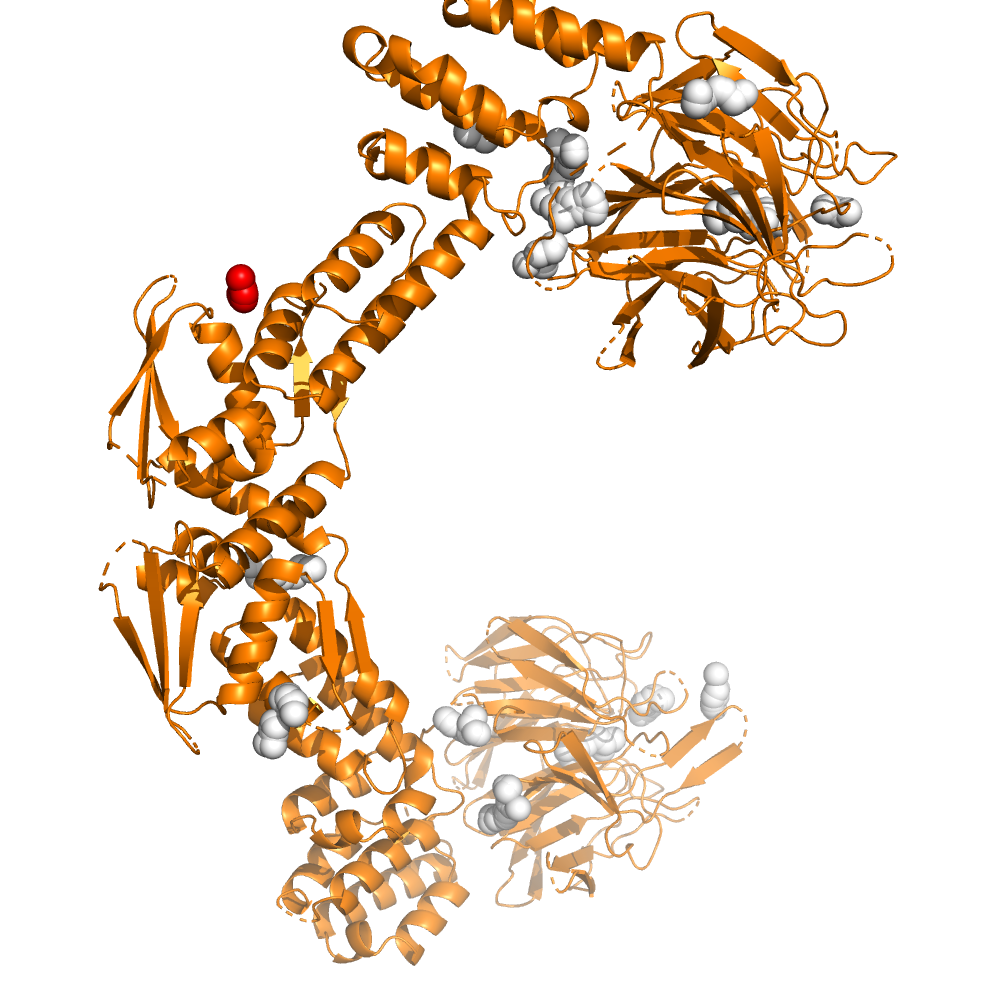

In [48]:
pock_num = filtered['pocket_num'].iloc[0]
cmd.delete('all')
cmd.load(f'./workdir/{pdb}_out/{pdb}_out.pdb')
cmd.color('red', f'resi {pock_num}')
cmd.png('view.png', 1000, 1000)
IPython.display.Image('view.png', retina=True)

In [ ]:
filtered.sort_values(by=['drugability', 'atoms_between', 'solvent_acess', 'mean_resi_depth', 'size'], ascending=[False, False, False, True, False]).to_csv('hits_sorted.csv', index = False)